In [1]:
import os
import tejapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# set tej_key and base
tej_key = 'OwzRIrnJ2M5z38YjbBGKOGGJyiZAtG'
api_base = 'http://10.10.10.66'

os.environ['TEJAPI_KEY'] = tej_key
os.environ['TEJAPI_BASE'] = api_base

# tejapi.ApiConfig.api_key = tej_key
# tejapi.ApiConfig.api_base = api_base

# set date
start = '2022-01-01'
end = '2023-01-01'
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = '2330'

In [2]:
!zipline ingest -b tquant

Merging daily equity files:


[2024-01-12 05:23:26.331910] INFO: zipline.data.bundles.core: Ingesting tquant.


In [3]:
from zipline.data import bundles
from zipline.pipeline import Pipeline
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline.pipeline.data import EquityPricing, TWEquityPricing
from zipline.pipeline.factors import BollingerBands, TrueRange, CustomFactor
from zipline.utils.math_utils import nanmax
from numpy import dstack

start_time = pd.Timestamp(start, tz = 'UTC')
end_time = pd.Timestamp(end,tz = 'UTC')
bundle = bundles.load('tquant')

class AverageTrueRange(CustomFactor):

    inputs = (
        EquityPricing.high,
        EquityPricing.low,
        EquityPricing.close,
    )
    
    window_length = 20

    outputs = ["TR", "SMA_ATR"]
    
    def compute(self, today, assets, out, highs, lows, closes):

        high_to_low = highs[1:] - lows[1:]
        high_to_prev_close = abs(highs[1:] - closes[:-1])
        low_to_prev_close = abs(lows[1:] - closes[:-1])
        tr_current = nanmax(
            dstack(
                (
                    high_to_low,
                    high_to_prev_close,
                    low_to_prev_close,
                )
            ),
            2,
        )

        sma_atr_values = np.mean(tr_current, axis=0)
        
        out.TR = tr_current[-1]
        out.SMA_ATR = sma_atr_values

def make_pipeline():
    
    ATR = AverageTrueRange(inputs = [TWEquityPricing.high,
                                     TWEquityPricing.low,
                                     TWEquityPricing.close])
    TR = TrueRange(
        inputs=[TWEquityPricing.high,
                TWEquityPricing.low,
                TWEquityPricing.close]
    )
    perf = BollingerBands(inputs=[EquityPricing.close], window_length=20, k=2)
    upper,middle,lower = perf.upper, perf.middle, perf.lower
    curr_price = EquityPricing.close.latest
    
    return Pipeline(
        columns={
            'SMA_ATR': ATR.SMA_ATR,
            'upper': upper,
            'middle': middle,
            'lower': lower,
            'curr_price': curr_price
        },
    )

pipeline_result = run_pipeline(make_pipeline(), start_time, end_time)
pipeline_result 

,,SMA_ATR,upper,middle,lower,curr_price
2022-01-04 00:00:00+00:00,Equity(0 [2330]),NaN,631.000000,631.000000,631.000000,631.0
2022-01-05 00:00:00+00:00,Equity(0 [2330]),NaN,668.500000,643.500000,618.500000,656.0
2022-01-06 00:00:00+00:00,Equity(0 [2330]),NaN,666.979156,645.666667,624.354177,650.0
2022-01-07 00:00:00+00:00,Equity(0 [2330]),NaN,663.763509,645.250000,626.736491,644.0
2022-01-10 00:00:00+00:00,Equity(0 [2330]),NaN,661.846750,643.000000,624.153250,634.0
...,...,...,...,...,...,...
2022-12-26 00:00:00+00:00,Equity(0 [2330]),10.015883,495.811271,474.605632,453.399993,455.0
2022-12-27 00:00:00+00:00,Equity(0 [2330]),9.415138,496.098595,473.543132,450.987670,456.5
2022-12-28 00:00:00+00:00,Equity(0 [2330]),9.338450,495.276002,472.182492,449.088982,457.0
2022-12-29 00:00:00+00:00,Equity(0 [2330]),8.975450,494.139699,470.372711,446.605723,451.0


In [4]:
from zipline.api import *
from zipline.finance import commission, slippage

def initialize(context):
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.PerShare(cost = 0.001425 + 0.003 / 2))
    set_benchmark(symbol('2330'))
    attach_pipeline(make_pipeline(), 'mystrategy')
    context.last_buy_price = 0
    context.stop_loss = 0

In [5]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrategy')
    for i in out_dir.index: 
        curr_price = out_dir.loc[i, 'curr_price']
        upper = out_dir.loc[i, 'upper']
        lower = out_dir.loc[i, 'lower']
        
        cash_position = context.portfolio.cash
        stock_position = context.portfolio.positions[i].amount

        loss_stopped, buy, sell = False, False, False
        record(price = curr_price, upper = upper, lower = lower, buy = buy, sell = sell)

        if (curr_price <= lower) and (cash_position >= curr_price * 1000):
            order(i, 1000)
            buy = True
            record(buy = buy)
            # context.last_buy_price = curr_price
        
        elif (curr_price >= upper) and (stock_position >= 1000):
            order_target(i, 0)
            sell = True
            record(sell = sell)
        else:
            pass

In [6]:
def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel("Portfolio value (NTD)")
    ax2 = fig.add_subplot(212)
    ax2.set_ylabel("Stock Price (NTD)")
    perf.price.plot(ax=ax2)
    perf.upper.plot(ax=ax2)
    perf.lower.plot(ax=ax2)
    
    buy_status, sell_status = perf.buy, perf.sell
    buy_status.fillna(False, inplace=True)
    sell_status.fillna(False, inplace=True)
    
    ax2.plot( # 繪製買入訊號
        perf.index[perf.buy],
        perf.loc[perf.buy, 'price'],
        '^',
        markersize=5,
        color='red'
    )
    ax2.plot( # 繪製賣出訊號
        perf.index[perf.sell],
        perf.loc[perf.sell, 'price'],
        'v',
        markersize=5,
        color='green'
    )
    
    plt.legend(loc=0)
    plt.gcf().set_size_inches(18,8)
    plt.show()

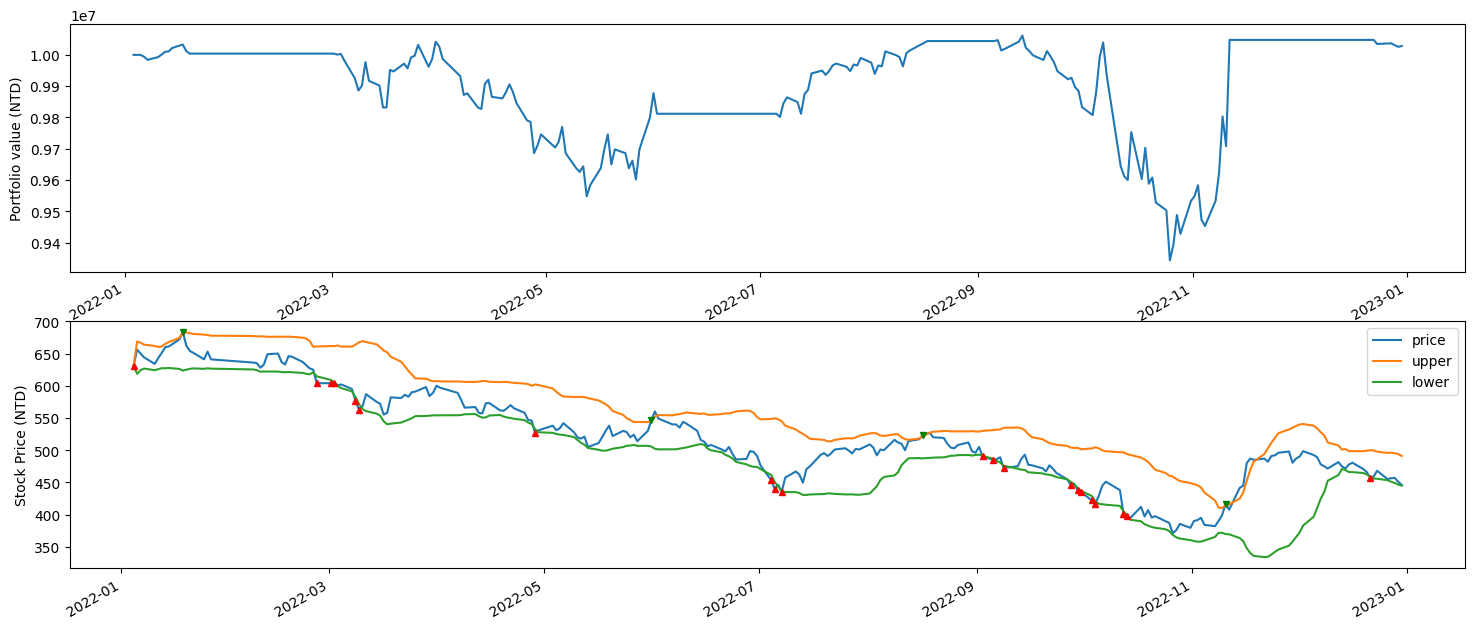

,period_open,period_close,long_exposure,short_exposure,pnl,starting_value,gross_leverage,net_leverage,capital_used,ending_value,...,period_label,treasury_period_return,benchmark_period_return,excess_return,benchmark_volatility,price,upper,lower,buy,sell
2022-01-03 13:30:00+08:00,2022-01-03 09:01:00+08:00,2022-01-03 13:30:00+08:00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,2022-01,0.0,0.019386,-0.019386,NaN,NaN,NaN,NaN,False,False
2022-01-04 13:30:00+08:00,2022-01-04 09:01:00+08:00,2022-01-04 13:30:00+08:00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,2022-01,0.0,0.059774,-0.059774,0.227124,631.0,631.000000,631.000000,True,False
2022-01-05 13:30:00+08:00,2022-01-05 09:01:00+08:00,2022-01-05 13:30:00+08:00,650000.0,0.0,-2.925012,0.0,0.065000,0.065000,-650002.925012,650000.0,...,2022-01,0.0,0.050082,-0.050082,0.388929,656.0,668.500000,618.500000,False,False
2022-01-06 13:30:00+08:00,2022-01-06 09:01:00+08:00,2022-01-06 13:30:00+08:00,644000.0,0.0,-6000.000000,650000.0,0.064439,0.064439,0.000000,644000.0,...,2022-01,0.0,0.040389,-0.040989,0.378078,650.0,666.979156,624.354177,False,False
2022-01-07 13:30:00+08:00,2022-01-07 09:01:00+08:00,2022-01-07 13:30:00+08:00,634000.0,0.0,-10000.000000,644000.0,0.063502,0.063502,0.000000,634000.0,...,2022-01,0.0,0.024234,-0.025834,0.374778,644.0,663.763509,626.736491,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26 13:30:00+08:00,2022-12-26 09:01:00+08:00,2022-12-26 13:30:00+08:00,456500.0,0.0,1500.000000,455000.0,0.045485,0.045485,0.000000,456500.0,...,2022-12,0.0,-0.246234,0.249872,0.324641,455.0,495.811271,453.399993,False,False
2022-12-27 13:30:00+08:00,2022-12-27 09:01:00+08:00,2022-12-27 13:30:00+08:00,457000.0,0.0,500.000000,456500.0,0.045532,0.045532,0.000000,457000.0,...,2022-12,0.0,-0.245408,0.249096,0.323976,456.5,496.098595,450.987670,False,False
2022-12-28 13:30:00+08:00,2022-12-28 09:01:00+08:00,2022-12-28 13:30:00+08:00,451000.0,0.0,-6000.000000,457000.0,0.044961,0.044961,0.000000,451000.0,...,2022-12,0.0,-0.255315,0.258403,0.323545,457.0,495.276002,449.088982,False,False
2022-12-29 13:30:00+08:00,2022-12-29 09:01:00+08:00,2022-12-29 13:30:00+08:00,446000.0,0.0,-5000.000000,451000.0,0.044485,0.044485,0.000000,446000.0,...,2022-12,0.0,-0.263571,0.266159,0.323044,451.0,494.139699,446.605723,False,False


In [7]:
from zipline import run_algorithm

results = run_algorithm(
    start = start_time,
    end = end_time,
    initialize=initialize,
    bundle='tquant',
    analyze=analyze,
    capital_base=1e7,
    handle_data = handle_data
)

results

In [8]:
# results['loss_stopped'].fillna(False, inplace=True)
# results[results['loss_stopped'] == True]

In [9]:
results[results['sell'] == True]

,period_open,period_close,long_exposure,short_exposure,pnl,starting_value,gross_leverage,net_leverage,capital_used,ending_value,...,period_label,treasury_period_return,benchmark_period_return,excess_return,benchmark_volatility,price,upper,lower,buy,sell
2022-01-18 13:30:00+08:00,2022-01-18 09:01:00+08:00,2022-01-18 13:30:00+08:00,662000.0,0.0,-21000.0,683000.0,0.066121,0.066121,0.0,662000.0,...,2022-01,0.0,0.069468,-0.068269,0.302517,683.0,682.856640,623.506997,False,True
2022-05-31 13:30:00+08:00,2022-05-31 09:01:00+08:00,2022-05-31 13:30:00+08:00,3360000.0,0.0,78000.0,3282000.0,0.340159,0.340159,0.0,3360000.0,...,2022-05,0.0,-0.090834,0.078607,0.273825,547.0,545.702681,505.597319,False,True
2022-08-16 13:30:00+08:00,2022-08-16 09:01:00+08:00,2022-08-16 13:30:00+08:00,1575000.0,0.0,6000.0,1569000.0,0.156901,0.156901,0.0,1575000.0,...,2022-08,0.0,-0.143026,0.146846,0.288210,523.0,521.343904,487.206096,False,True
2022-11-10 13:30:00+08:00,2022-11-10 09:01:00+08:00,2022-11-10 13:30:00+08:00,4075000.0,0.0,-95000.0,4170000.0,0.419761,0.419761,0.0,4075000.0,...,2022-11,0.0,-0.330992,0.301783,0.311989,417.0,414.336543,369.763457,False,True


In [10]:
results.head(180).tail(10)

,period_open,period_close,long_exposure,short_exposure,pnl,starting_value,gross_leverage,net_leverage,capital_used,ending_value,...,period_label,treasury_period_return,benchmark_period_return,excess_return,benchmark_volatility,price,upper,lower,buy,sell
2022-09-15 13:30:00+08:00,2022-09-15 09:01:00+08:00,2022-09-15 13:30:00+08:00,1429500.0,0.0,-10500.000000,1440000.0,0.142776,0.142776,0.000000,1429500.0,...,2022-09,0.0,-0.217713,0.218931,0.284017,477.25,524.745434,465.548316,False,False
2022-09-16 13:30:00+08:00,2022-09-16 09:01:00+08:00,2022-09-16 13:30:00+08:00,1416000.0,0.0,-13500.000000,1429500.0,0.141619,0.141619,0.000000,1416000.0,...,2022-09,0.0,-0.225100,0.224968,0.283357,476.50,520.282718,465.262959,False,False
2022-09-19 13:30:00+08:00,2022-09-19 09:01:00+08:00,2022-09-19 13:30:00+08:00,1401000.0,0.0,-15000.000000,1416000.0,0.140329,0.140329,0.000000,1401000.0,...,2022-09,0.0,-0.233310,0.231678,0.282754,472.00,517.078036,463.965558,False,False
2022-09-20 13:30:00+08:00,2022-09-20 09:01:00+08:00,2022-09-20 13:30:00+08:00,1429500.0,0.0,28500.000000,1401000.0,0.142776,0.142776,0.000000,1429500.0,...,2022-09,0.0,-0.217713,0.218931,0.283145,467.00,513.795052,462.345886,False,False
2022-09-21 13:30:00+08:00,2022-09-21 09:01:00+08:00,2022-09-21 13:30:00+08:00,1413000.0,0.0,-16500.000000,1429500.0,0.141361,0.141361,0.000000,1413000.0,...,2022-09,0.0,-0.226743,0.226311,0.282600,476.50,511.177327,461.905798,False,False
2022-09-22 13:30:00+08:00,2022-09-22 09:01:00+08:00,2022-09-22 13:30:00+08:00,1393500.0,0.0,-19500.000000,1413000.0,0.139683,0.139683,0.000000,1393500.0,...,2022-09,0.0,-0.237413,0.235031,0.282187,471.00,509.606222,460.465653,False,False
2022-09-23 13:30:00+08:00,2022-09-23 09:01:00+08:00,2022-09-23 13:30:00+08:00,1365000.0,0.0,-28500.000000,1393500.0,0.137218,0.137218,0.000000,1365000.0,...,2022-09,0.0,-0.253010,0.247778,0.282303,464.50,508.352080,458.157972,False,False
2022-09-26 13:30:00+08:00,2022-09-26 09:01:00+08:00,2022-09-26 13:30:00+08:00,1339500.0,0.0,-25500.000000,1365000.0,0.135001,0.135001,0.000000,1339500.0,...,2022-09,0.0,-0.266964,0.259182,0.282247,455.00,506.617363,454.883731,False,False
2022-09-27 13:30:00+08:00,2022-09-27 09:01:00+08:00,2022-09-27 13:30:00+08:00,1344000.0,0.0,4500.000000,1339500.0,0.135393,0.135393,0.000000,1344000.0,...,2022-09,0.0,-0.264502,0.257171,0.281514,446.50,504.159089,451.085338,True,False
2022-09-28 13:30:00+08:00,2022-09-28 09:01:00+08:00,2022-09-28 13:30:00+08:00,1752000.0,0.0,-30002.925031,1344000.0,0.177029,0.177029,-438002.925031,1752000.0,...,2022-09,0.0,-0.280920,0.270588,0.281799,448.00,503.383295,447.096731,False,False


In [11]:
import pyfolio as pf 
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results['benchmark_return'] 

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

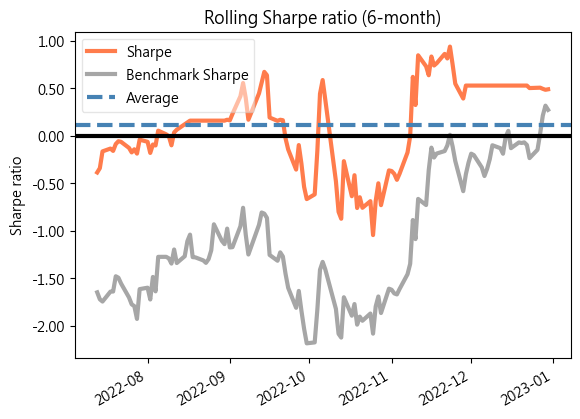

In [12]:
from pyfolio.plotting import plot_rolling_sharpe
plot_rolling_sharpe(returns,
                    factor_returns=benchmark_rets
                       )

In [13]:
from pyfolio.plotting import show_worst_drawdown_periods
show_worst_drawdown_periods(returns, top=5)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.14,2022-09-13,2022-10-25,NaT,NaN
1,4.92,2022-03-30,2022-05-12,2022-08-17,97
2,2.00,2022-01-17,2022-03-15,2022-03-30,45
3,0.33,2022-09-06,2022-09-07,2022-09-13,5
4,0.16,2022-01-04,2022-01-07,2022-01-11,6


<AxesSubplot:ylabel='Cumulative returns'>

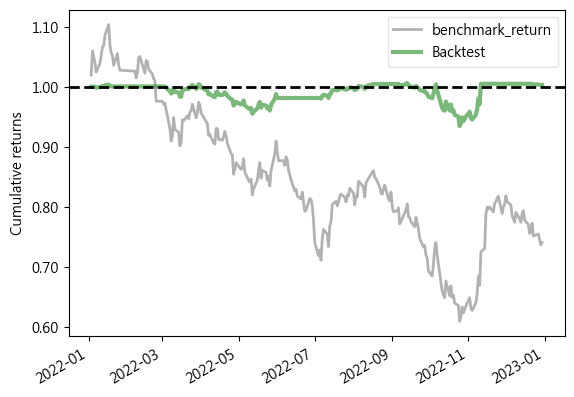

In [14]:
benchmark_rets = results['benchmark_return'] 
pf.plotting.plot_rolling_returns(returns, factor_returns=benchmark_rets)

<AxesSubplot:title={'center':'Rolling volatility (6-month)'}, ylabel='Volatility'>

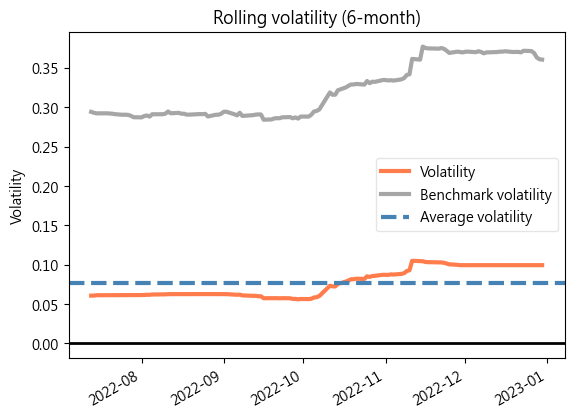

In [15]:
from pyfolio.plotting import plot_rolling_volatility
plot_rolling_volatility(returns,
                        factor_returns=benchmark_rets)

In [16]:
pf.plotting.show_perf_stats(
        returns,
        benchmark_rets,
        positions=positions,
        transactions=transactions)

Start date,2022-01-03
End date,2022-12-30
Total months,11
,Backtest
Annual return,0.291%
Cumulative returns,0.284%
Annual volatility,8.266%
Sharpe ratio,0.08
Calmar ratio,0.04
Stability,0.00
Max drawdown,-7.144%


,Backtest
Annual return,0.291%
Cumulative returns,0.284%
Annual volatility,8.266%
Sharpe ratio,0.076205
Calmar ratio,0.040698
Stability,0.000812
Max drawdown,-7.144%
Omega ratio,1.018479
Sortino ratio,0.11263
Skew,0.600202
